In [1]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing the required libraries
!pip install sentencepiece optuna
!pip install torch huggingface_hub
!pip install transformers datasets 
!pip install rouge.score nltk py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.5 MB/s 
     |████████████████████████████████| 348 kB 69.1 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 74.6 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 147 kB 75.1 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 66.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6e660b4f50e255749906ff2dc3035870f862a73081255fa7d1cf06949f1c50ab
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 34.3

In [3]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import nltk
import optuna
import transformers

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
# Create function for printing 
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

# Specify our parameter and project variables
# These parameter range can be changed with respect to amount of processing power available (GPU)
LR_MIN = 4e-5
LR_CEIL = 0.01
WD_MIN = 4e-5
WD_CEIL = 0.01
MIN_EPOCHS = 8
MAX_EPOCHS = 15
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.0
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
MODEL_NAME = 't5-base'
MAX_INPUT = 512
MAX_TARGET = 128

# Selecting the first 1000 rows just to see if the GPU issue doesnt recreate as the dataset is large
dataset_path = 'gdrive/My Drive/fyp/xsum/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:1000]

metric = datasets.load_metric('rouge')
data

,document,summary
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...
...,...,...
995,"If confirmed, the ""exomoon"" is likely to be ab...",A team of astronomers has potentially discover...
996,"Jacob Murphy fired in a 25-yard shot, his firs...",Norwich City made a great start to life back i...
997,"Speaking to reporters at the G20 summit, the u...",David Cameron has made an impassioned defence ...
998,"The Swans are up to 12th in the table, 13 poin...",Swansea City head coach Francesco Guidolin bel...


In [11]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [12]:
# Preprocessing the data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #get the document text
    if 't5' in MODEL_NAME: 
        inputs = [prefix + doc for doc in data_to_process["document"]]
    else:
        inputs = [document for document in data_to_process['document']]

    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})


In [13]:
# Preprocess the data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(500))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(250))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(100))
     
# Update the tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 250
    })
})

In [15]:
#load model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# We are using batch_size to handle with the GPU limitation but if GPU size is not a limitation please use the recommend batch size from the hyperparameters
batch_size = 1

#data_collator to create batches. It preprocess data with the given tokenizer
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [16]:
#####################
# metrics
# compute rouge for evaluation 
#####################

def compute_rouge(pred):
    predictions, labels = pred
    #decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    #compute the average of the rouge scores
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [17]:
# Performing hyperparameter training
print_custom('Performing hyperparameter training....')
def objective(trial: optuna.Trial):
    # Specify the training arguments and hyperparameter tune every arguments which are possible to tune
    training_args = transformers.Seq2SeqTrainingArguments(
        report_to="none",
        save_total_limit=1,
        output_dir=SAVE_DIR,
        run_name=MODEL_NAME,
        save_strategy="epoch",
        greater_is_better=True,
        predict_with_generate=True,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        weight_decay=trial.suggest_float("weight_decay", WD_MIN, WD_CEIL, log=True),
        learning_rate=trial.suggest_float("learning_rate", LR_MIN, LR_CEIL, log=True),
        num_train_epochs=trial.suggest_int("num_train_epochs", MIN_EPOCHS, MAX_EPOCHS),
        warmup_ratio=trial.suggest_float("warmup_ratio", WARMUP_RATIO_MIN, WARMUP_RATIO_MAX),
        per_device_eval_batch_size=trial.suggest_int("per_device_eval_batch_size", MIN_BATCH_SIZE, MAX_BATCH_SIZE),
        per_device_train_batch_size=trial.suggest_int("per_device_train_batch_size", MIN_BATCH_SIZE, MAX_BATCH_SIZE),
    )

    # Create the trainer
    trainer = transformers.Seq2SeqTrainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        eval_dataset=tokenize_data["test"],
        train_dataset=tokenize_data["train"],
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate()

    # Return the loss
    return metrics["eval_loss"]

# Create the study
print_custom('Creating the study')
study = optuna.create_study(direction="minimize")

# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

# Optimize the objective function
print_custom('Optimizing the objective function')
study.optimize(objective, n_trials=NUM_TRIALS)


[I 2022-12-14 10:19:14,783] A new study created in memory with name: no-name-0d436297-52cb-4e70-bb52-411473730e5e




Performing hyperparameter training....
----------------------------------------------------------------------------------------------------


Creating the study
----------------------------------------------------------------------------------------------------


Optimizing the objective function
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 500
  Num Epochs = 15
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 222903552
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.527979
2,No log,0.528490
3,No log,0.560756
4,No log,0.605062
5,0.683400,0.672760
6,0.683400,0.705908
7,0.683400,0.734909
8,0.683400,0.772262
9,0.683400,0.774041
10,0.070000,0.786183


***** Running Evaluation *****
  Num examples = 100
  Batch size = 6
Saving model checkpoint to opt-test/checkpoint-100
Configuration saved in opt-test/checkpoint-100/config.json
Model weights saved in opt-test/checkpoint-100/pytorch_model.bin
tokenizer config file saved in opt-test/checkpoint-100/tokenizer_config.json
Special tokens file saved in opt-test/checkpoint-100/special_tokens_map.json
Copy vocab file to opt-test/checkpoint-100/spiece.model
***** Running Evaluation *****
  Num examples = 100
  Batch size = 6
Saving model checkpoint to opt-test/checkpoint-200
Configuration saved in opt-test/checkpoint-200/config.json
Model weights saved in opt-test/checkpoint-200/pytorch_model.bin
tokenizer config file saved in opt-test/checkpoint-200/tokenizer_config.json
Special tokens file saved in opt-test/checkpoint-200/special_tokens_map.json
Copy vocab file to opt-test/checkpoint-200/spiece.model
Deleting older checkpoint [opt-test/checkpoint-100] due to args.save_total_limit
***** Runni

[I 2022-12-14 10:43:16,839] Trial 0 finished with value: 0.816501796245575 and parameters: {'weight_decay': 8.412864052517414e-05, 'learning_rate': 0.00032662033897519575, 'num_train_epochs': 15, 'warmup_ratio': 0.04268196211945612, 'per_device_eval_batch_size': 6, 'per_device_train_batch_size': 5}. Best is trial 0 with value: 0.816501796245575.


In [18]:
# Print the best parameters
print_custom('Printing the best parameters')
print(study.best_params)

# Hyperparameter results
learning_rate = study.best_params['learning_rate']
weight_decay = study.best_params['weight_decay']
num_train_epochs = study.best_params['num_train_epochs']
warmup_ratio = study.best_params['warmup_ratio']
per_device_train_batch_size = study.best_params['per_device_train_batch_size']
per_device_eval_batch_size = study.best_params['per_device_eval_batch_size']

# Create the training arguments
args = transformers.Seq2SeqTrainingArguments(
    'generalization-summary',
    evaluation_strategy='epoch',
    learning_rate=learning_rate,
    per_device_train_batch_size=1, # this is due to GPU limitation else per_device_train_batch_size should be used 
    per_device_eval_batch_size= 1, # this is due to GPU limitation else per_device_eval_batch_size should be used
    gradient_accumulation_steps=2,
    weight_decay=weight_decay,
    save_total_limit=2,
    warmup_ratio=warmup_ratio,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )
#only CUDA available -> fp16=True

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)
     
# !nvidia-smi

# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

# Train the model
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend




Printing the best parameters
----------------------------------------------------------------------------------------------------
{'weight_decay': 8.412864052517414e-05, 'learning_rate': 0.00032662033897519575, 'num_train_epochs': 15, 'warmup_ratio': 0.04268196211945612, 'per_device_eval_batch_size': 6, 'per_device_train_batch_size': 5}


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 500
  Num Epochs = 15
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 2
  Total optimization steps = 3750
  Number of trainable parameters = 222903552


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.022812,75.197600,70.900700,74.367300,74.487300,18.844000
2,0.063800,0.025599,75.297700,71.001800,74.531600,74.534500,18.892000
3,0.063800,0.014508,78.321900,75.546000,77.829600,77.873700,18.836000
4,0.067600,0.008198,78.461300,76.093400,78.239100,78.332400,18.824000
5,0.067600,0.005407,79.957700,78.359400,79.832400,79.902800,18.872000
6,0.032300,0.003742,80.078600,78.585000,79.945600,79.952800,18.864000
7,0.032300,0.003123,80.656400,79.608700,80.672000,80.676800,18.848000
8,0.017100,0.001702,80.661600,79.589900,80.614900,80.655100,18.864000
9,0.017100,0.001026,80.736900,79.734500,80.757600,80.767000,18.864000
10,0.010600,0.000348,80.753600,79.756300,80.771100,80.792700,18.864000


***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
Saving model checkpoint to generalization-summary/checkpoint-500
Configuration saved in generalization-summary/checkpoint-500/config.json
Model weights saved in generalization-summary/checkpoint-500/pytorch_model.bin
tokenizer config file saved in generalization-summary/checkpoint-500/tokenizer_config.json
Special tokens file saved in generalization-summary/checkpoint-500/special_tokens_map.json
Copy vocab file to generalization-summary/checkpoint-500/spiece.model
***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
***** Running Evaluation *****
  Num examples = 250
  Batch size = 1
Saving model checkpoint to generalization-summary/checkpoint-1000
Configuration saved in generalization-summary/checkpoint-1000/config.json
Model weights saved in generalization-summary/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in generalization-summary/checkpoint-1000/tokenizer_config.json
Special toke

TrainOutput(global_step=3750, training_loss=0.027293045965830483, metrics={'train_runtime': 2573.062, 'train_samples_per_second': 2.915, 'train_steps_per_second': 1.457, 'total_flos': 4567184179200000.0, 'train_loss': 0.027293045965830483, 'epoch': 15.0})

In [19]:
# Clearing the cuda memory
torch.cuda.empty_cache()

# Evaluate the model
metrics = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 250
  Batch size = 1




Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.00010732583177741617, 'eval_rouge1': 80.7536, 'eval_rouge2': 79.7563, 'eval_rougeL': 80.7711, 'eval_rougeLsum': 80.7927, 'eval_gen_len': 18.864, 'eval_runtime': 91.7906, 'eval_samples_per_second': 2.724, 'eval_steps_per_second': 2.724, 'epoch': 15.0}


Creating a line graph for the metrics
----------------------------------------------------------------------------------------------------


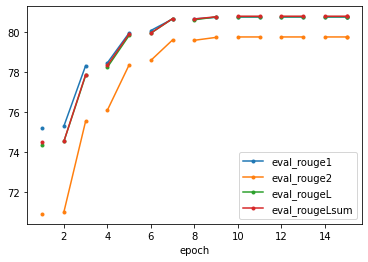

In [20]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('Creating a line graph for the metrics')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Creating the validation loss graph
----------------------------------------------------------------------------------------------------


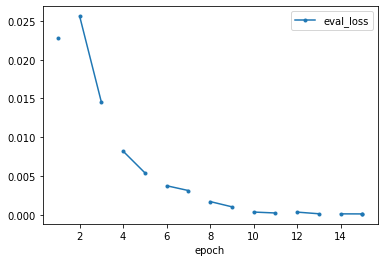

In [21]:
# Creating the validation loss graph 
print_custom('Creating the validation loss graph')
df.plot(x='epoch', y=['eval_loss'], style='.-')

In [22]:
# Testing the fine tuned model
document = 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we\'re neglected or forgotten," she said.\n"That may not be true but it is perhaps my perspective over the last few days.\n"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"\nMeanwhile, a flood alert remains in place across the Borders because of the constant rain.\nPeebles was badly hit by problems, sparking calls to introduce more defences in the area.\nScottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.\nThe Labour Party\'s deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.\nHe said it was important to get the flood protection plan right but backed calls to speed up the process.\n"I was quite taken aback by the amount of damage that has been done," he said.\n"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."\nHe said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.\nHave you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.'

model_inputs = tokenizer(document,  max_length=MAX_INPUT, padding='max_length', truncation=True)

raw_pred, _, _ = trainer.predict([model_inputs])

# creating a function remove all html tags from the text
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

output = tokenizer.decode(raw_pred[0])


cleaned_output = remove_html_tags(output)
cleaned_output

# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/Models/' + MODEL_NAME + '_model'
model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/Models/' + MODEL_NAME + '_tokenizer'
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

***** Running Prediction *****
  Num examples = 1
  Batch size = 1


Configuration saved in gdrive/My Drive/fyp/Models/t5-base_model/config.json
Model weights saved in gdrive/My Drive/fyp/Models/t5-base_model/pytorch_model.bin
tokenizer config file saved in gdrive/My Drive/fyp/Models/t5-base_tokenizer/tokenizer_config.json
Special tokens file saved in gdrive/My Drive/fyp/Models/t5-base_tokenizer/special_tokens_map.json
Copy vocab file to gdrive/My Drive/fyp/Models/t5-base_tokenizer/spiece.model


('gdrive/My Drive/fyp/Models/t5-base_tokenizer/tokenizer_config.json',
 'gdrive/My Drive/fyp/Models/t5-base_tokenizer/special_tokens_map.json',
 'gdrive/My Drive/fyp/Models/t5-base_tokenizer/spiece.model',
 'gdrive/My Drive/fyp/Models/t5-base_tokenizer/added_tokens.json',
 'gdrive/My Drive/fyp/Models/t5-base_tokenizer/tokenizer.json')